# LSTM for a sequential problem

## First LSTM trial based on HAMIDS example LSTM with starbucks stock data

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/CNielsen94/NN_exercises_AAUBSDS/main/Assignment%202%20-%20CNN%20and%20RNN/AAPL_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates=True)

In [3]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


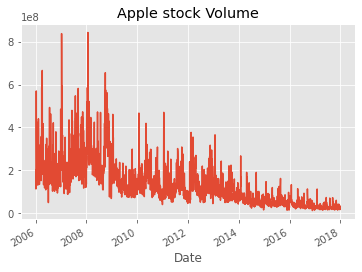

In [4]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Apple stock Volume')

In [5]:
X = df.iloc[:, :-2]
y = df.iloc[:, 4:5] 

In [6]:
y

,Volume
Date,
2006-01-03,201853036
2006-01-04,155225609
2006-01-05,112396081
2006-01-06,176139334
2006-01-09,168861224
...,...
2017-12-22,16349444
2017-12-26,33185536
2017-12-27,21498213


In [7]:
X

,Open,High,Low,Close
Date,,,,
2006-01-03,10.34,10.68,10.32,10.68
2006-01-04,10.73,10.85,10.64,10.71
2006-01-05,10.69,10.70,10.54,10.63
2006-01-06,10.75,10.96,10.65,10.90
2006-01-09,10.96,11.03,10.82,10.86
...,...,...,...,...
2017-12-22,174.68,175.42,174.50,175.01
2017-12-26,170.80,171.47,169.68,170.57
2017-12-27,170.10,170.78,169.71,170.60


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [9]:
#first 2200 for training

X_train = X_ss[:2200, :]
X_test = X_ss[2200:, :]

y_train = y_mm[:2200, :]
y_test = y_mm[2200:, :] 

In [10]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (2200, 4) (2200, 1)
Testing Shape (819, 4) (819, 1)


In [11]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [12]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 4
hidden_size = 16
output_size = 1
num_epochs= 10

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

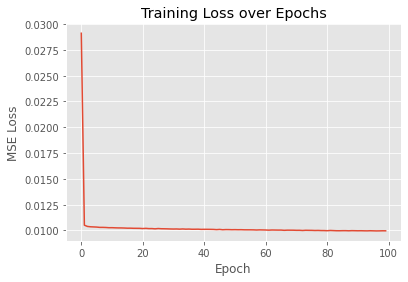

In [13]:
# Initializing Hyperparameters
num_epochs = 100
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [14]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.00645316577812432


In [15]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

In [16]:
# data_predict[0]

NameError: ignored

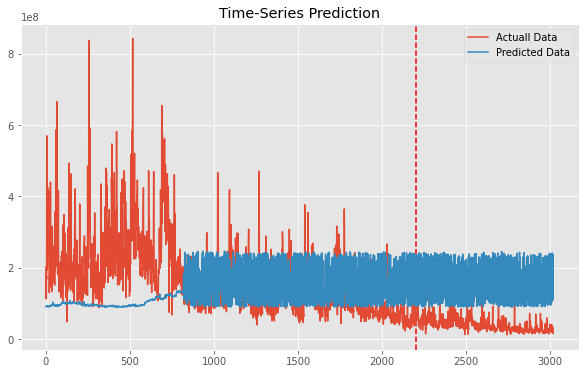

In [17]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y.Volume.values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=2200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [18]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

<All keys matched successfully>

## Second LSTM trial, changing parameters

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/CNielsen94/NN_exercises_AAUBSDS/main/Assignment%202%20-%20CNN%20and%20RNN/AAPL_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates=True)

In [20]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


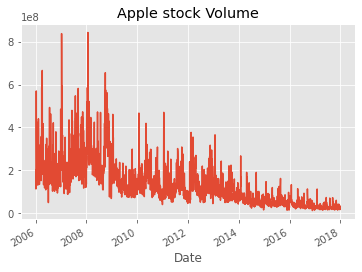

In [21]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Apple stock Volume')

In [22]:
X = df.iloc[:, :-2]
y = df.iloc[:, 4:5] 

In [ ]:
y

In [ ]:
X

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [24]:
#first 2200 for training

X_train = X_ss[:2500, :]
X_test = X_ss[2500:, :]

y_train = y_mm[:2500, :]
y_test = y_mm[2500:, :] 

In [25]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (2500, 4) (2500, 1)
Testing Shape (519, 4) (519, 1)


In [26]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [27]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 4
hidden_size = 6
output_size = 1
num_epochs= 5

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

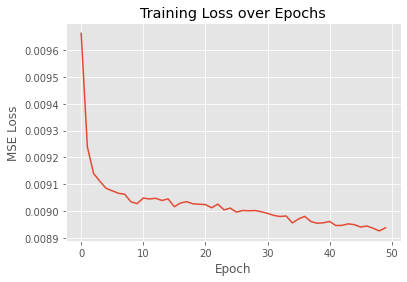

In [28]:
# Initializing Hyperparameters
num_epochs = 50
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [29]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.001265097954979077


In [30]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

In [ ]:
data_predict[0]

In [32]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
# dataY_plot = y.Volume.values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=2500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

AttributeError: ignored

In [ ]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

#chatGPT trial LSTM

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [ ]:
# Split the data into training and testing sets
train_data = df[df['Date'] < '2015-01-01'].copy()
test_data = df[df['Date'] >= '2015-01-01'].copy()

In [ ]:
train_data

In [ ]:
test_data

In [ ]:
# Normalize the data
train_mean = train_data['Close'].mean()
train_std = train_data['Close'].std()

In [ ]:
train_data['Close'] = (train_data['Close'] - train_mean) / train_std
test_data['Close'] = (test_data['Close'] - train_mean) / train_std

In [ ]:
# Convert data to tensors
train_data = torch.tensor(train_data['Close'].values, dtype=torch.float).view(-1, 1)
test_data = torch.tensor(test_data['Close'].values, dtype=torch.float).view(-1, 1)

In [ ]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
epochs = 100
for i in range(epochs):
    for j in range(train_data.shape[0] - 1):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        
        inputs = train_data[j:(j+1)].view(1, 1, 1)
        target = train_data[j+1:j+2].view(1, 1, 1)

        prediction = model(inputs)
        loss = loss_function(prediction, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()